In [ ]:
import warnings
warnings.filterwarnings('ignore')

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint

Detected objects: 26
Resizing depth_color from (384, 384) to (191, 263)


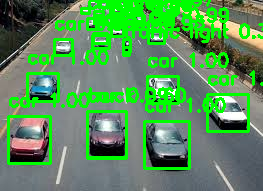

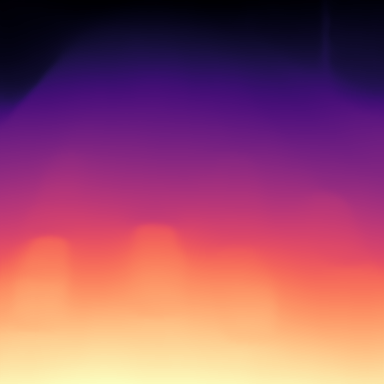

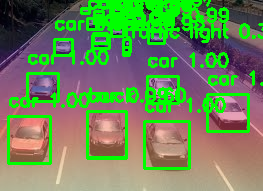

In [ ]:
import torch
import cv2
import numpy as np
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import DPTImageProcessor, DPTForDepthEstimation
import matplotlib.cm as cm
from google.colab.patches import cv2_imshow # Import cv2_imshow

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------
# Load DETR
# --------------------------
detr_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
det_model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50").to(DEVICE)

# --------------------------
# Load MiDaS
# --------------------------
midas_processor = DPTImageProcessor.from_pretrained("intel/dpt-large")
midas_model = DPTForDepthEstimation.from_pretrained("intel/dpt-large").to(DEVICE)


# --------------------------
# Depth → Color Map
# --------------------------
def depth_to_color(depth):
    depth_min = depth.min()
    depth_max = depth.max()
    depth_norm = (depth - depth_min) / (depth_max - depth_min)
    depth_colored = cm.magma(depth_norm)[:, :, :3]
    depth_colored = (depth_colored * 255).astype(np.uint8)
    depth_colored = cv2.cvtColor(depth_colored, cv2.COLOR_RGB2BGR)
    return depth_colored


# --------------------------
# Processing Pipeline
# --------------------------
def process_image(path):

    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise ValueError(f"Could not load image from path: {path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # ------------------------
    # 1) DETR Object Detection
    # ------------------------
    inputs = detr_processor(images=img_rgb, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = det_model(**inputs)

    target_sizes = torch.tensor([img_rgb.shape[:2]]).to(DEVICE)

    results = detr_processor.post_process_object_detection(
        outputs,
        target_sizes=target_sizes,
        threshold=0.3    # ↓↓↓ مهم جداً لظهور البوكسات
    )[0]

    print("Detected objects:", len(results["scores"]))

    # ==================================================
    # رسم البوكسات على النسخة الأصلية قبل depth map
    # ==================================================
    det_img = img_bgr.copy()

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):

        # تحويل الصندوق لأرقام صحيحة
        x1, y1, x2, y2 = [int(v) for v in box.tolist()]

        cls_name = det_model.config.id2label[label.item()]
        score = float(score)

        cv2.rectangle(det_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(det_img, f"{cls_name} {score:.2f}",
                    (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)


    # ------------------------
    # 2) MiDaS Depth Estimation
    # ------------------------
    midas_inputs = midas_processor(images=img_rgb, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        depth = midas_model(**midas_inputs).predicted_depth[0]

    depth = depth.cpu().numpy()
    depth_color = depth_to_color(depth)

    # Ensure depth_color has the same dimensions as img_bgr for overlay
    if depth_color.shape[:2] != img_bgr.shape[:2]:
        print(f"Resizing depth_color from {depth_color.shape[:2]} to {img_bgr.shape[:2]}")
        depth_color_resized = cv2.resize(depth_color, (img_bgr.shape[1], img_bgr.shape[0]), interpolation=cv2.INTER_LINEAR)
    else:
        depth_color_resized = depth_color

    # -------------------------------------
    # 3) دمج depth map مع الصورة الأصلية
    # -------------------------------------
    overlay = cv2.addWeighted(img_bgr, 0.5, depth_color_resized, 0.5, 0)

    # رسم البوكسات فوق overlay كمان
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):

        x1, y1, x2, y2 = [int(v) for v in box.tolist()]
        cls_name = det_model.config.id2label[label.item()]
        score = float(score)

        cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(overlay, f"{cls_name} {score:.2f}",
                    (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.6, (0, 255, 0), 2)

    return det_img, depth_color, overlay


# --------------------------
# Run
# --------------------------
if __name__ == "__main__":
    img = "/content/download (20).jpg"

    det_img, depth_map, overlay = process_image(img)

    cv2_imshow(det_img) # Changed to cv2_imshow
    cv2_imshow(depth_map) # Changed to cv2_imshow
    cv2_imshow(overlay) # Changed to cv2_imshow
    # cv2.waitKey(0) # Removed as not needed with cv2_imshow
    # cv2.destroyAllWindows() # Removed as not needed with cv2_imshow

    cv2.imwrite("1_detr_boxes.png", det_img)
    cv2.imwrite("2_depth_map.png", depth_map)
    cv2.imwrite("3_final_overlay.png", overlay)


In [ ]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import BartForConditionalGeneration, BartTokenizer
from google.colab import files
import soundfile as sf
import numpy as np
import librosa  # لازم تثبتيه: !pip install librosa

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --------------------------
# Whisper-small
# --------------------------
whisper_model_name = "openai/whisper-small"
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_name)
whisper_model = WhisperForConditionalGeneration.from_pretrained(whisper_model_name).to(DEVICE)

# --------------------------
# BART-large-cnn
# --------------------------
bart_model_name = "facebook/bart-large-cnn"
bart_tokenizer = BartTokenizer.from_pretrained(bart_model_name)
bart_model = BartForConditionalGeneration.from_pretrained(bart_model_name).to(DEVICE)

# --------------------------
# رفع ملف صوتي
# --------------------------
uploaded = files.upload()  # اختاري ملف WAV من جهازك
audio_path = list(uploaded.keys())[0]

# قراءة الصوت
audio, fs = sf.read(audio_path)
# إذا الصوت ستيريو حوله لمونو
if len(audio.shape) > 1:
    audio = audio.mean(axis=1)

# --------------------------
# إعادة تكييف العينة للصوت إلى 16kHz
# --------------------------
audio_16k = librosa.resample(audio, orig_sr=fs, target_sr=16000)
fs = 16000  # ضبط sampling rate الجديد

# --------------------------
# تحويل الصوت لنص
# --------------------------
def speech_to_text(audio, fs):
    audio = audio / np.max(np.abs(audio))
    input_features = whisper_processor(audio, sampling_rate=fs, return_tensors="pt").input_features.to(DEVICE)
    with torch.no_grad():
        predicted_ids = whisper_model.generate(input_features)
    transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

# --------------------------
# تلخيص النص
# --------------------------
def summarize_text(text, max_length=150):
    inputs = bart_tokenizer([text], return_tensors="pt", truncation=True, max_length=1024).to(DEVICE)
    summary_ids = bart_model.generate(inputs["input_ids"], num_beams=4, max_length=max_length, early_stopping=True)
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# --------------------------
# التنفيذ
# --------------------------
print("\n--- Converting Speech to Text ---")
text = speech_to_text(audio_16k, fs)
print("Transcription:\n", text)

print("\n--- Summarizing Text ---")
summary = summarize_text(text)
print("Summary:\n", summary)


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Saving mission-save-christmas.mp3 to mission-save-christmas.mp3

--- Converting Speech to Text ---


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription:
  Short and sweet stories. A good idea for Muma Blue. Mission, save Christmas. It's Christmas Eve and you cannot sleep. You feel butterflies in your tummy. You are too excited waiting for Santa Claus to arrive.

--- Summarizing Text ---
Summary:
 Short and sweet stories. A good idea for Muma Blue. Mission, save Christmas. It's Christmas Eve and you cannot sleep. You feel butterflies in your tummy. You are too excited waiting for Santa Claus to arrive. Short and sweet. stories. MumaBlue.com.
